# Creating a model that can detect different expressions in a face given their images.

In [3]:
# Importing libraries required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

## Performing Data Processing

In [14]:
# Creating the Pathlib PATH objects
train_path = Path("./dataset/train")
test_path = Path("./dataset/test")

# Getting Image paths 
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

train_image_paths[:10]

['dataset\\train\\angry\\Training_10118481.jpg',
 'dataset\\train\\angry\\Training_10120469.jpg',
 'dataset\\train\\angry\\Training_10131352.jpg',
 'dataset\\train\\angry\\Training_10161559.jpg',
 'dataset\\train\\angry\\Training_1021836.jpg',
 'dataset\\train\\angry\\Training_10269675.jpg',
 'dataset\\train\\angry\\Training_10278738.jpg',
 'dataset\\train\\angry\\Training_10290703.jpg',
 'dataset\\train\\angry\\Training_10295477.jpg',
 'dataset\\train\\angry\\Training_10315441.jpg']

In [16]:
# Getting their respective labels 

def get_label(image_path):
    return image_path.split("\\")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

['angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry']

#### Performing encoding in our train_image_labels to normalise labels and to convert our string labels into numerical labels.

In [17]:
from sklearn.preprocessing import LabelEncoder 

label_encoder = LabelEncoder()
train_image_labels = label_encoder.fit_transform(train_image_labels)

train_image_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

#### Converting encoded array into matrix according to each label.
`1 for correct label and 0 for wrong`

In [18]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

### Splitting the dataset into training and validation datasets with 75-25 percentage ratio.

In [9]:
from sklearn.model_selection import train_test_split 

train_image_paths , val_image_paths , train_image_labels , val_image_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)

#### Normalising the weights of each label to remove biasing from the model.

In [10]:
classTotals = train_image_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {label : weight for label , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.8044132, 1: 15.920354, 2: 1.7511356, 3: 1.0, 4: 1.454325, 5: 1.4954281, 6: 2.2468777}


#### Converting our image into tensors.

In [19]:
def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

### Performing Data Augmentation on our images to make our model more robust and perform well on real images.

In [20]:
# Define IMAGE SIZE and BATCH SIZE 
image_size = 96 
batch_size = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(image_size, image_size)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [21]:
# Function used to create a Tensorflow Data Object
autotune = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=autotune)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=autotune)
    
    dataset = dataset.repeat()
    return dataset

In [14]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(train_image_paths , train_image_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 2.38 s, sys: 43.8 ms, total: 2.43 s

Wall time: 2.55 s

(32, 96, 96, 3)

(32, 7)



#### Viewing a sample Training Image

sad


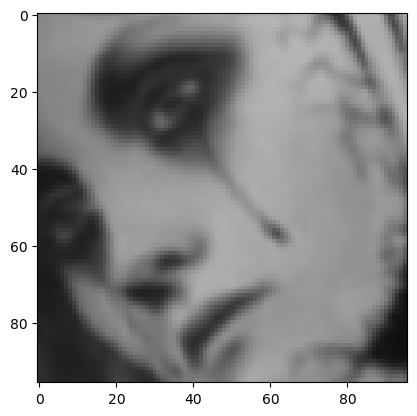

In [15]:
print(label_encoder.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [16]:
# Creating Validation Dataset object and Verifying it
%time val_dataset = get_dataset(val_image_paths , val_image_labels, train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 27.2 ms, sys: 2.03 ms, total: 29.2 ms

Wall time: 28.7 ms

(32, 96, 96, 3)

(32, 7)


surprise


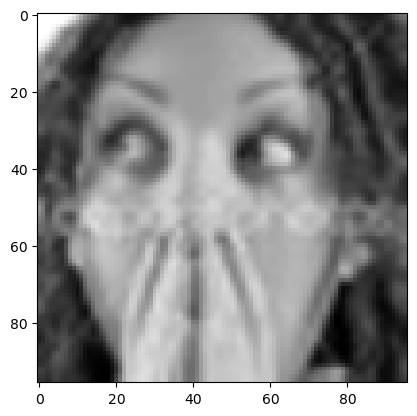

In [17]:
# View a sample Validation Image
print(label_encoder.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

## Model Building

In [8]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 64,kernel_size = (5, 5),input_shape = (96, 96, 3),activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 64,kernel_size = (5, 5),input_shape = (96, 96, 3),activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters = 128,kernel_size = (3, 3),activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 128,kernel_size = (3, 3),activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters = 256,kernel_size = (3, 3),activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 256,kernel_size = (3, 3),activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters = 512,kernel_size = (3, 3),activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 512,kernel_size = (3, 3),activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.15),

    tf.keras.layers.Flatten(name='flatten'),
    tf.keras.layers.Dense(512,activation='relu',),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 92, 92, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 88, 88, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 44, 64)       0         
 )                                                               
                                                        

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

## Model Training

In [20]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_image_paths)//batch_size,
    epochs=25,
    validation_data=val_dataset,
    validation_steps = len(val_image_paths)//batch_size,
    class_weight=class_weight
)

Epoch 1/25


2023-03-22 09:48:46.572289: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


672/672 [==============================] - 107s 132ms/step - loss: 3.7738 - accuracy: 0.1846 - precision: 0.1998 - recall: 0.0271 - val_loss: 2.0954 - val_accuracy: 0.1878 - val_precision: 0.2691 - val_recall: 0.0575

Epoch 2/25

672/672 [==============================] - 91s 133ms/step - loss: 3.4960 - accuracy: 0.2113 - precision: 0.3360 - recall: 0.0294 - val_loss: 1.8945 - val_accuracy: 0.2411 - val_precision: 0.4735 - val_recall: 0.0449

Epoch 3/25

672/672 [==============================] - 89s 133ms/step - loss: 3.3374 - accuracy: 0.2588 - precision: 0.4742 - recall: 0.0572 - val_loss: 1.8393 - val_accuracy: 0.2641 - val_precision: 0.6461 - val_recall: 0.0481

Epoch 4/25

672/672 [==============================] - 88s 132ms/step - loss: 3.1899 - accuracy: 0.3034 - precision: 0.5445 - recall: 0.0910 - val_loss: 2.1129 - val_accuracy: 0.1724 - val_precision: 0.3763 - val_recall: 0.0049

Epoch 5/25

672/672 [==============================] - 90s 134ms/step - loss: 2.9261 - accuracy

### ACCURACY - 63.24%
#### considerably very good given our large dataset of facial images incorporating a lot of noise. This value of metric puts our model in one of the best performing models that exist in this domain. 

In [24]:
model.save_weights("best_weights.h5")

In [10]:
from keras.utils import plot_model
tf.keras.utils.plot_model(model, to_file='cnn_model_layer.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Model Testing

#### Compling the model and loading the saved weights for our trained model.

In [33]:
# Load weights
model.load_weights("./best_weights.h5")

#### Preparing the test dataset in our preprocessed form to pass into the model.

In [34]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_path = Path("./dataset/test")
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = label_encoder.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(batch_size)
)

In [35]:
# Verify Test Dataset Object

image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


surprise


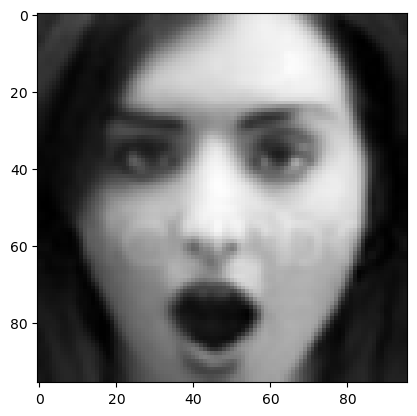

In [20]:
# View a sample Validation Image

print(label_encoder.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

### Evaluating the loaded model

In [37]:
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

225/225 [==============================] - 99s 439ms/step - loss: 1.2139 - accuracy: 0.5525 - precision: 0.6660 - recall: 0.4416
 Testing Acc :  0.5525215864181519
 Testing Precision  0.6659663915634155
 Testing Recall  0.4416272044181824


#### Saving the Model and LabelEncoder files, model weights saved earlier

In [22]:
# Save Model
model.save("FacialExpressionModel.h5")

# Save Label Encoder 
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

save_object(label_encoder, "LabelEncoder")